In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

In [ ]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


In [ ]:
config = dict(
    data = dict(
        look_back=60,
    ),
    model=dict(
        input_dim = 1,
        hidden_dim = 32,
        num_layers = 2,
        output_dim = 1,
    ),
    inference=dict(
    )
)

## 2. Load data

In [ ]:
def load_stock_price_dataset(symbol):
    return pd.read_csv(
            f"/content/{symbol.lower()}.us.txt", 
            index_col='datetime', 
            parse_dates={'datetime': ['<DATE>', '<TIME>']},
            usecols=['<DATE>', '<TIME>', '<CLOSE>'], 
            na_values=['nan']
    ).rename(columns={'<CLOSE>': 'y'})    

In [ ]:
SYMBOL = 'META'
df = load_stock_price_dataset(SYMBOL)

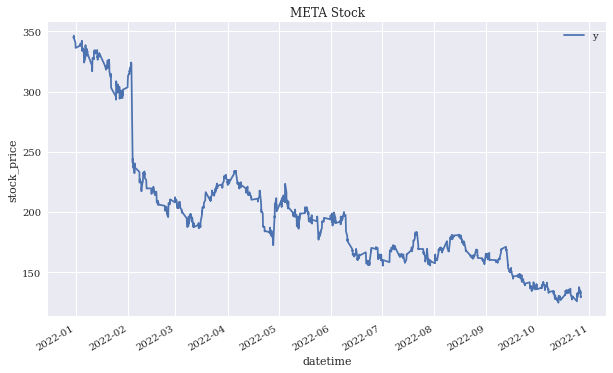

In [ ]:
df.plot(figsize=(10, 6), subplots=True);
plt.ylabel("stock_price")
plt.title(f"{SYMBOL} Stock");

In [ ]:
import datetime

def split_time_series(df, cutoff_datetime):
    if isinstance(cutoff_datetime, str):
        cutoff_datetime = datetime.datetime.fromisoformat(cutoff_datetime)
    start_date = df.index.min()
    end_date = df.index.max()
    assert cutoff_datetime > start_date
    assert cutoff_datetime < end_date
    return df[:cutoff_datetime].copy(), df[cutoff_datetime:].copy()

In [ ]:
# function to create train, test data given stock data and sequence length
def load_data(scaler, df, look_back):
    data_raw = df.values # convert to numpy array
    data = []
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(scaler.transform(data_raw[index: index + look_back]))
    
    data = np.array(data);
    x = data[:,:-1]
    y = data[:,-1,:]
    return x, y

In [ ]:
train_df, val_df = split_time_series(df, '2022-09-01')
len(train_df), len(val_df)

(1183, 273)

In [ ]:
scaler = StandardScaler()
scaler.fit(train_df.y.values.reshape(-1, 1))

StandardScaler()

In [ ]:
look_back = config['data']['look_back'] # choose sequence length
x_train, y_train = load_data(scaler, train_df, look_back)
x_val, y_val = load_data(scaler, val_df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_val.shape = ',x_val.shape)
print('y_val.shape = ',y_val.shape)

x_train.shape =  (1123, 59, 1)
y_train.shape =  (1123, 1)
x_val.shape =  (213, 59, 1)
y_val.shape =  (213, 1)


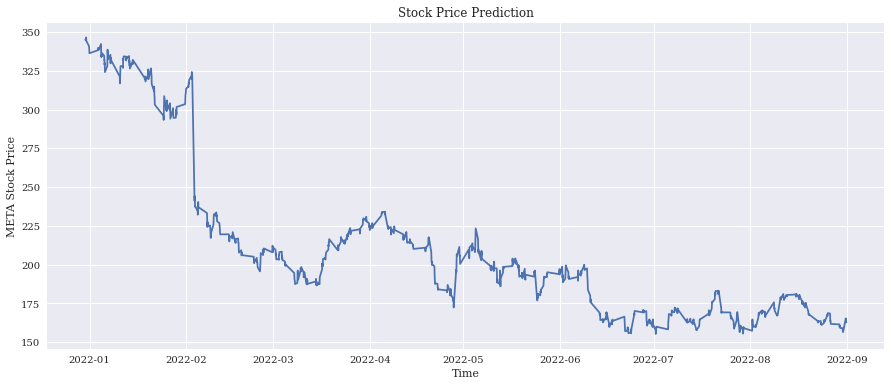

In [ ]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(train_df.index, train_df.y.values )
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{SYMBOL} Stock Price')
plt.legend()
plt.show()

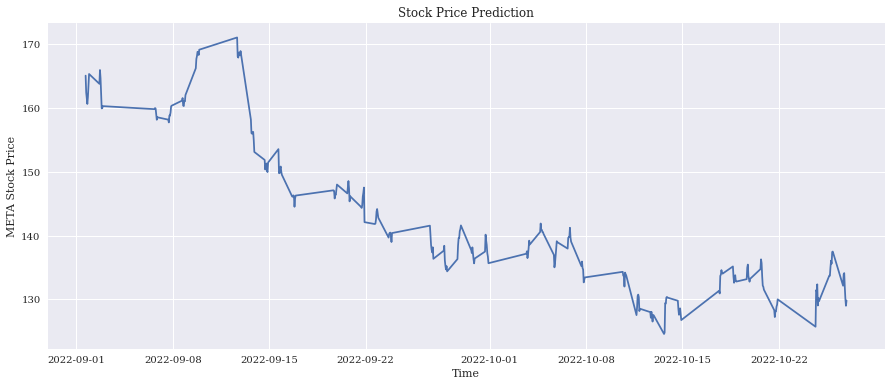

In [ ]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(val_df.index, val_df.y.values )
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{SYMBOL} Stock Price')
plt.legend()
plt.show()

## 3. Build the structure of model

In [ ]:
# Here we define our model as a class
class ForecastLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden_state=None):
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, hidden_state)

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out, (hn.detach(), cn.detach())
    
model = ForecastLSTM(**config['model'])

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

ForecastLSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
# make training and test sets in torch
xt_train = torch.from_numpy(x_train).type(torch.Tensor)
yt_train = torch.from_numpy(y_train).type(torch.Tensor)
xt_val = torch.from_numpy(x_val).type(torch.Tensor)
yt_val = torch.from_numpy(y_val).type(torch.Tensor)

In [ ]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    yt_train_pred, _ = model(xt_train)

    loss = loss_fn(yt_train_pred, yt_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.06797405332326889
Epoch  20 MSE:  0.012541515752673149
Epoch  30 MSE:  0.010154790244996548
Epoch  40 MSE:  0.008641146123409271
Epoch  50 MSE:  0.007743199355900288
Epoch  60 MSE:  0.007110412698239088
Epoch  70 MSE:  0.006658269092440605
Epoch  80 MSE:  0.0063482350669801235
Epoch  90 MSE:  0.006108911707997322


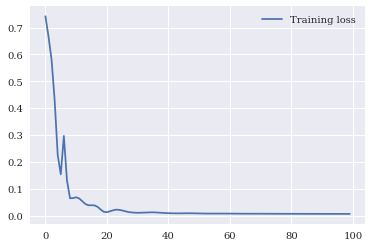

In [ ]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    yt_val_pred, _ = model(xt_val)

# calculate root mean squared error
score_train = math.sqrt(mean_squared_error(y_train[:,0], yt_train_pred.detach().numpy()[:,0]))
score_val = math.sqrt(mean_squared_error(y_val[:,0], yt_val_pred.detach().numpy()[:,0]))
print('Train Score: %.2f RMSE' % (score_train))
print('Val. Score: %.2f RMSE' % (score_val))

Train Score: 0.08 RMSE
Val. Score: 0.12 RMSE


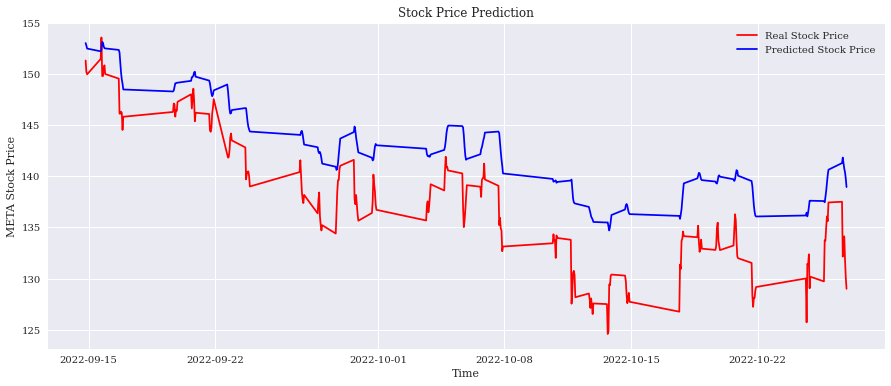

In [ ]:
# Visualising the results
val_price = scaler.inverse_transform(y_val)
val_price_pred = scaler.inverse_transform(yt_val_pred.detach().numpy())

figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_val):].index, val_price, color = 'red', label = 'Real Stock Price')
axes.plot(df[len(df)-len(y_val):].index, val_price_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{SYMBOL} Stock Price')
plt.legend()
plt.show()

## Inference

In [ ]:
class Forecaster:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model

    def __call__(self, x: np.ndarray, n: int):
        # x.shape: (N, )
        self.model.eval()
        output = []
        for i in range(n):
            xnew = self._predict_one(x)
            output.append(xnew)
            x = np.concatenate([x[1:], [xnew]])
        return output            

    def _predict_one(self, x):
        # x.shape: (N,)
        x = self.preprocessor.transform(x.reshape(-1, 1))
        with torch.no_grad():
            # xnew.shape: (1, 1)
            xnew, _ = self.model(torch.from_numpy(x[None, :, :]).type(torch.float))
        return self.preprocessor.inverse_transform(xnew.detach().numpy()).item()


In [ ]:
forecaster = Forecaster(scaler, model)

In [ ]:
n_future = 24
history_start = 0
history_end = history_start + look_back - 1
history_df = val_df.iloc[history_start: history_end]
future_df = val_df.iloc[history_end: history_end + n_future]
pred_price = forecaster(history_df.y.values, len(future_df))

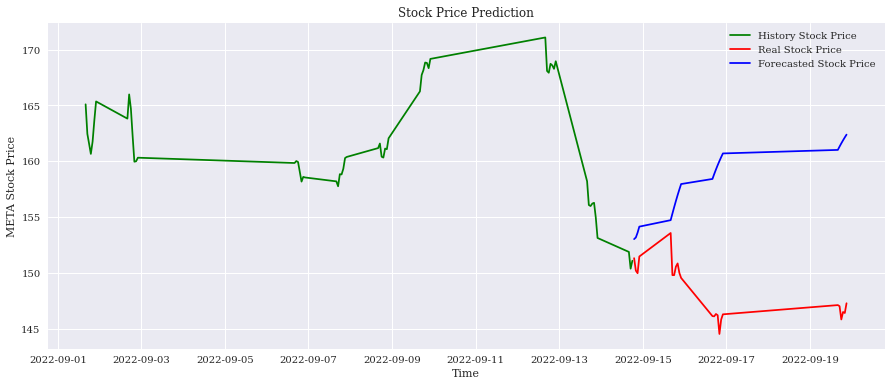

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(history_df.index, history_df.y.values, color = 'green', label = 'History Stock Price')
axes.plot(future_df.index, future_df.y.values, color = 'red', label = 'Real Stock Price')
axes.plot(future_df.index, pred_price, color = 'blue', label = 'Forecasted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{SYMBOL} Stock Price')
plt.legend()
plt.show()

## Save & Load

In [ ]:
import torch
import pickle

pickle.dump(scaler, open('preprocessor.pkl', 'wb'))
torch.save(model.state_dict(), 'model.pth')

In [ ]:
import pickle
from sklearn.preprocessing import StandardScaler
import torch

def build_forecaster(config, preprocessor_filepath, model_filepath):
    preprocessor = pickle.load(open(preprocessor_filepath, 'rb'))
    model = ForecastLSTM(**config['model'])
    model.load_state_dict(torch.load(model_filepath))
    forecaster = Forecaster(preprocessor, model)
    return forecaster

In [ ]:
forecaster = build_forecaster(config, 'preprocessor.pkl', 'model.pth')